In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [90]:
def Db(vx, vy, bx, by, wv, hv, wb, hb, N):
    """
    Function to calculate the bin density Db of
    a particular bin b

    Parameters:
        v_x, v_y: Lists of the center x- and y- coordinates, respectively, of each vertex
        b_x, b_y: Center x- and y- coordinates, respectively, of this bin
        wv, hv: Lists of the widths and heights, respectively, of each vertex
        wb, hb: Width and height, respectively, of this bin
        N: (Length of vectors vx, vy, wv, hv) / 2

    Return:
        Value of Db for this bin b
    """
    val = 0.0
    #Iterate over verticies/cells/clusters in this bin
    for i in np.arange(N):
        #Calculate p_x(b,v)
        p_x = 0.0
        p_y = 0.0
        abs_dx = np.abs(vx[i] - bx)
        a = 4.0/((wv[i] + 2.0*wb)*(wv[i] + 4.0*wb))
        b = 2.0/(wb*(wv[i] + 4.0*wb))
        if abs_dx <= (0.5*wv[i] + wb):
            p_x = 1.0 - a*(abs_dx**2)
        elif (abs_dx >= (0.5*wv[i] + wb)) and (abs_dx <= (0.5*wv[i] + 2.0*wb)):
            p_x = b*((abs_dx - 0.5*wv[i] - 2.0*wb)**2)
        else:
            p_x = 0.0
        #Calculate p_y(b,v)
        abs_dy = np.abs(vy[i] - by)
        a = 4.0/((hv[i] + 2.0*hb)*(hv[i] + 4.0*hb))
        b = 2.0/(hb*(hv[i] + 4.0*hb))
        if abs_dy <= (0.5*hv[i] + hb):
            p_y = 1.0 - a*(abs_dy**2)
        elif (abs_dy >= (0.5*hv[i] + hb)) and (abs_dy <= (0.5*hv[i] + 2.0*hb)):
            p_y = b*((abs_dy - 0.5*hv[i] - 2.0*hb)**2)
        else:
            p_y = 0.0
        #Now, calculate proportion of cell/cluster's area that lies inside
        #this bin for normalization factor
        cv = (max(0,min(bx + 0.5*wb, vx[i] + 0.5*wv[i]) - max(bx - 0.5*wb, vx[i] - 0.5*wv[i]))*max(0,min(by + 0.5*hb, vy[i] + 0.5*hv[i]) - max(by - 0.5*hb, vy[i] - 0.5*hv[i])))/(wv[i]*hv[i])#Normalization factor
        cv = 1.0
        #print("Potential: " + str(p_x*p_y) + "     Area: " + str(wv[i]*hv[i]))
        val += cv*p_x*p_y
        
    return val

def f(x, w, h, bin_x, bin_y):
    """
    Function to calculate the sum of the Db's over all the bins

    Parameters:
        x: Vector of x,y coordinates of vertex/cell/cluster centers, x-coordinates first
        w: Array of vertex/cell widths. w[i] is the width of vertex/cell with center (x[i],x[i+N])
        h: Array of vertex/cell heights. h[i] is the height of vertex/cell with center (x[i],x[i+N])
        bin_x: Numpy meshgrid of bin top-left x-coordinates, with indexing='ij'
        bin_y: Numpy meshgrid of bin top-left y-coordinates, with indexing='ij'

    Return:
        Value of sum of the Db's over all bins
    """
    N = x.shape[0] // 2
    Nx = bin_x.shape[0]#Grid should be square
    Ny = bin_y.shape[1]#Grid should be square
    wb = bin_x[1][0] - bin_x[0][0]
    hb = bin_y[0][1] - bin_y[0][0]
    Mb = wb*hb#All area inside the bin can be moved - there are no pre-placed cells
    fval = 0.0
    for j in np.arange(Ny-1):
        for i in np.arange(Nx-1):
            #Potential movable area calculation requires all verticies
            fval += Db(x[:N], x[N:], bin_x[i][j] + 0.5*wb, bin_y[i][j] + 0.5*hb, w, h, wb, hb, N)
    return fval

def dDb(vx, vy, bx, by, wv, hv, wb, hb, N):
    """
    Function to calculate the bin density Db of
    a particular bin b

    Parameters:
        v_x, v_y: Lists of the center x- and y- coordinates, respectively, of
                  each vertex 
        b_x, b_y: Center x- and y- coordinates, respectively, of this bin
        wv, hv: Lists of the widths and heights, respectively, of each vertex
        wb, hb: Width and height, respectively, of this bin
        N: (Length of x vector of all vertex center coordinates) / 2

    Return:
        res: Vector of length 2N that represents gradient of Db 
    """
    Mb = wb*hb
    res = np.zeros(int(2*N), dtype=np.double)
    #Iterate over verticies/cells/clusters in this bin
    for i in np.arange(N):
        #Calculate p_x(b,v)
        p_x = 0.0
        p_x_dx = 0.0
        p_y = 0.0
        p_y_dy = 0.0
        abs_dx = np.abs(vx[i] - bx)
        dx = vx[i] - bx
        a = 4.0/((wv[i] + 2.0*wb)*(wv[i] + 4.0*wb))
        b = 2.0/(wb*(wv[i] + 4.0*wb))
        if abs_dx <= (0.5*wv[i] + wb):
            p_x = 1.0 - a*(abs_dx**2)
            p_x_dx = -2.0*a*dx
            if dx < 0:
                p_x_dx = 2.0*a*(bx - vx[i])
        elif (abs_dx >= (0.5*wv[i] + wb)) and (abs_dx <= (0.5*wv[i] + 2.0*wb)):
            p_x = b*((abs_dx - 0.5*wv[i] - 2.0*wb)**2)
            p_x_dx = 2.0*b*(dx - 0.5*wv[i] - 2.0*wb)
            if dx < 0:
                p_x_dx = -2.0*b*(bx - vx[i] - 0.5*wv[i] - 2.0*wb)
        else:
            p_x = 0.0
            p_x_dx = 0.0
        #Calculate p_y(b,v)
        abs_dy = np.abs(vy[i] - by)
        dy = vy[i] - by
        a = 4.0/((hv[i] + 2.0*hb)*(hv[i] + 4.0*hb))
        b = 2.0/(hb*(hv[i] + 4.0*hb))
        if abs_dy <= (0.5*hv[i] + hb):
            p_y = 1.0 - a*(abs_dy**2)
            p_y_dy = -2.0*a*dy
            if dy < 0:
                p_y_dy = 2.0*a*(by - vy[i])
        elif (abs_dy >= (0.5*hv[i] + hb)) and (abs_dy <= (0.5*hv[i] + 2.0*hb)):
            p_y = b*((abs_dy - 0.5*hv[i] - 2.0*hb)**2)
            p_y_dy = 2.0*b*(dy - 0.5*hv[i] - 2.0*hb)
            if dy < 0:
                p_y_dy = -2.0*b*(by - vy[i] - 0.5*hv[i] - 2.0*hb)
        else:
            p_y = 0.0
            p_y_dy = 0.0
        #Now, calculate proportion of cell/cluster's area that lies inside
        #this bin for normalization factor
        cv = (max(0,min(bx + 0.5*wb, vx[i] + 0.5*wv[i]) - max(bx - 0.5*wb, vx[i] - 0.5*wv[i]))*max(0,min(by + 0.5*hb, vy[i] + 0.5*hv[i]) - max(by - 0.5*hb, vy[i] - 0.5*hv[i])))/(wv[i]*hv[i])#Normalization factor
        cv = 1.0
        #Update del_f
        res[i] = cv*p_x_dx*p_y
        res[i+N] = cv*p_x*p_y_dy
        
    return res
    
def grad_f(x, w, h, bin_x, bin_y):
    """
    Function to calculate the sum of the Db's over all the bins

    Parameters:
        x: Vector of x,y coordinates of vertex/cell/cluster centers, x-coordinates first
        w: Array of vertex/cell widths. w[i] is the width of vertex/cell with center (x[i],x[i+N])
        h: Array of vertex/cell heights. h[i] is the height of vertex/cell with center (x[i],x[i+N])
        bin_x: Numpy meshgrid of bin top-left x-coordinates, with indexing='ij'
        bin_y: Numpy meshgrid of bin top-left y-coordinates, with indexing='ij'

    Return:
        Value of sum of the Db's over all bins
    """
    N = x.shape[0] // 2
    del_f = np.zeros(x.shape[0], dtype=np.double)
    Nx = bin_x.shape[0]#Grid should be square
    Ny = bin_y.shape[1]#Grid should be square
    wb = bin_x[1][0] - bin_x[0][0]
    hb = bin_y[0][1] - bin_y[0][0]
    Mb = wb*hb#All area inside the bin can be moved - there are no pre-placed cells
    for j in np.arange(Ny-1):
        for i in np.arange(Nx-1):
            #Potential movable area calculation uses all verticies
            res = dDb(x[:N], x[N:], bin_x[i][j] + 0.5*wb, bin_y[i][j] + 0.5*hb, w, h, wb, hb, N)
            del_f = del_f + res
    return del_f

In [91]:
def derivativeChecker(m, n, max_iters=32):
    """
    m,n are matrix/vector dimensions. max_iters is max. number of iterations, default is 32
    """
    x = np.random.uniform(0.7, 4.3, n)
    w = np.random.rand(n // 2)
    hh = np.random.rand(n // 2)
    bin_x, bin_y = np.meshgrid(np.linspace(0.0,5.0,6), np.linspace(0.0,5.0,6),indexing='ij')
    v = np.random.randn(n)

    max_iters = 32
    h = np.zeros(max_iters)
    err0 = np.zeros(max_iters)
    err1 = np.zeros(max_iters)

    for i in range(max_iters):
        h[i] = 2**(-i) # halve our stepsize every time
        fv = f(x + h[i]*v, w, hh, bin_x, bin_y)
        T0 = f(x, w, hh, bin_x, bin_y)
        T1 = T0 + h[i]*np.matmul(grad_f(x, w, hh, bin_x, bin_y).transpose(), v)
        err0[i] = np.linalg.norm(fv - T0) # this error should be linear
        err1[i] = np.linalg.norm(fv - T1) # this error should be quadratic

        #Print reult as string with format ('h = ', h, ', err0 = ', err0[i], ', err1 = ', err1[i])
        print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))

    #Plot Results
    plt.loglog(h, err0, linewidth=3)
    plt.loglog(h, err1, linewidth=3)
    plt.legend(['$||f(x) - T_0(x)||$', '$||f(x)-T_1(x)||$'], fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

h: 1.000e+00, 	 err0: 2.025e+01, 	 err1: 1.813e+01
h: 5.000e-01, 	 err0: 6.308e+00, 	 err1: 5.251e+00
h: 2.500e-01, 	 err0: 1.851e+00, 	 err1: 1.322e+00
h: 1.250e-01, 	 err0: 6.003e-01, 	 err1: 3.359e-01
h: 6.250e-02, 	 err0: 2.190e-01, 	 err1: 8.678e-02
h: 3.125e-02, 	 err0: 8.815e-02, 	 err1: 2.204e-02
h: 1.562e-02, 	 err0: 3.858e-02, 	 err1: 5.521e-03
h: 7.812e-03, 	 err0: 1.791e-02, 	 err1: 1.380e-03
h: 3.906e-03, 	 err0: 8.609e-03, 	 err1: 3.451e-04
h: 1.953e-03, 	 err0: 4.218e-03, 	 err1: 8.627e-05
h: 9.766e-04, 	 err0: 2.088e-03, 	 err1: 2.157e-05
h: 4.883e-04, 	 err0: 1.038e-03, 	 err1: 5.392e-06
h: 2.441e-04, 	 err0: 5.178e-04, 	 err1: 1.348e-06
h: 1.221e-04, 	 err0: 2.586e-04, 	 err1: 3.370e-07
h: 6.104e-05, 	 err0: 1.292e-04, 	 err1: 8.424e-08
h: 3.052e-05, 	 err0: 6.458e-05, 	 err1: 2.106e-08
h: 1.526e-05, 	 err0: 3.229e-05, 	 err1: 5.265e-09
h: 7.629e-06, 	 err0: 1.614e-05, 	 err1: 1.316e-09
h: 3.815e-06, 	 err0: 8.070e-06, 	 err1: 3.291e-10
h: 1.907e-06, 	 err0: 4.035e-06

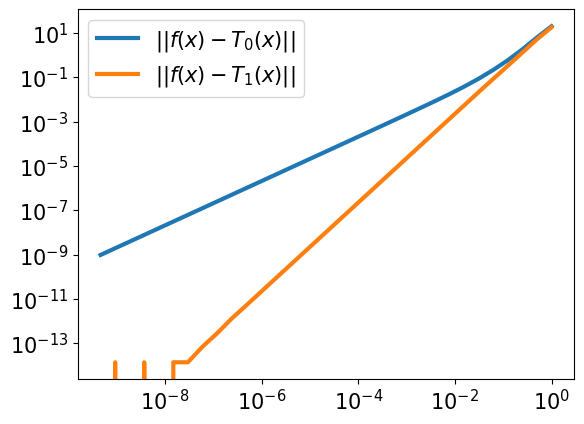

In [97]:
n = 44
derivativeChecker(n,n)